In [88]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import pandas as pd 
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, learning_curve
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.simplefilter('ignore')

#from imblearn.over_sampling import ADASYN, SMOTE
from scipy.stats import hmean

### Пути к директориям и файлам

In [89]:
df_train = pd.read_csv('C:/Users/yana/course_project/course_project_train.csv')
df_test = pd.read_csv('C:/Users/yana/course_project/course_project_test.csv')

In [90]:
# уменьшение потребляемой памяти
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:


                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [91]:
reduce_mem_usage(df_train)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.500000,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.500000,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.099998,1778920.0,0.0,NaN,0.0,buy a car,Short Term,100000000.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.500000,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [92]:
reduce_mem_usage(df_test)

Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.500000,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.700001,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.700000,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.000000,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.600000,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.100000,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,100000000.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.000000,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.800000,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.799999,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [93]:
#посмотрим пропуски
df_train.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [94]:
#посмотрим типы данных
df_train.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                         category
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
Credit Default                      int8
dtype: object

### Обзор данных

**Обзор целевой переменной**

In [95]:
df_train['Credit Default'].value_counts(normalize=True) # распределение дисбалансное, но не самое плохое 

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

In [96]:
df_train.value_counts('Credit Default')

Credit Default
0    5387
1    2113
dtype: int64

**Обзор количественных признаков**

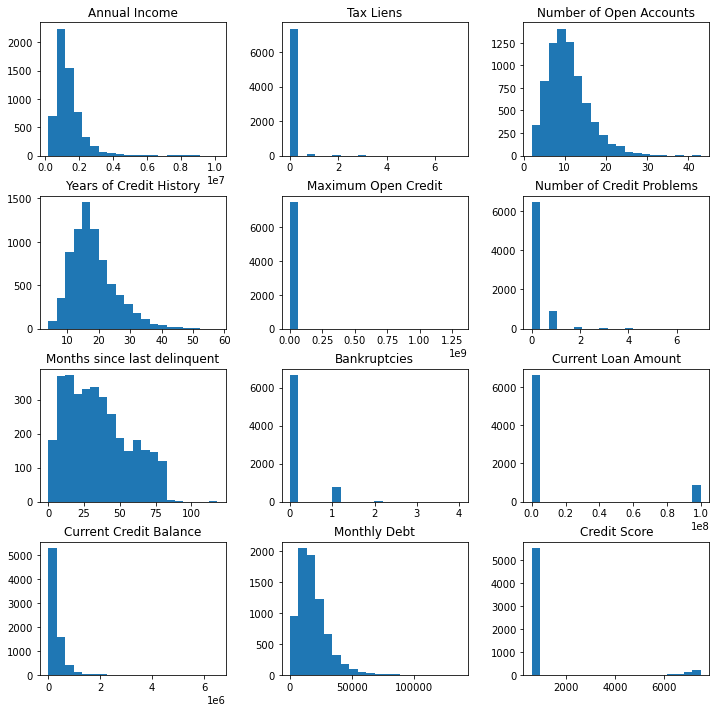

In [97]:
num_features = df_train.select_dtypes(exclude=['object'])
num_features.drop(['Credit Default'], axis=1, inplace=True)
num_features.hist(figsize=(12,12), bins=20, grid=False);

Tax Liens, Number of Credit Problems, Bankruptcies - большинство значений равны нулю, что не удивительно. Есть ощущение, что эти количественные признаки, а также Years in current job и Number of open accounts можно разбить на группы и перевести в категориальные.
Current Loan Amount, Current Credit Balance, Maximum Open Credit - есть явные выбросы. В >10 % от общего количества наблюдений Current Loan Amount = 100000000.0 и все "Credit Default" при этом значении равны нулю. Попытки усреднить это значение приводят к ухудшению результатов модели, отсюда вывод, что этот выброс лучше оставить, потому что он представляет собой особую категорию. То же самое с Credit Score: есть значения свыше 6000. Либо для нормализации их нужно разделить на 10, чтобы получить обычный credit score, либо это какая-то отдельная категория. Maximum Open Credit = 0 и Monthly Debt = 0 будем считать выбросами. 

In [98]:
df_train.loc[(df_train['Credit Score'] >6000) & (df_train['Credit Default'] ==0)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [99]:
df_train.loc[df_train['Credit Score'] >6000].shape[0]

400

400 случаев, и по всем "Credit Default" = 1. Скорее всего, данный выброс не случаен, поэтому не будем делить аномальный Credit Score на 10.

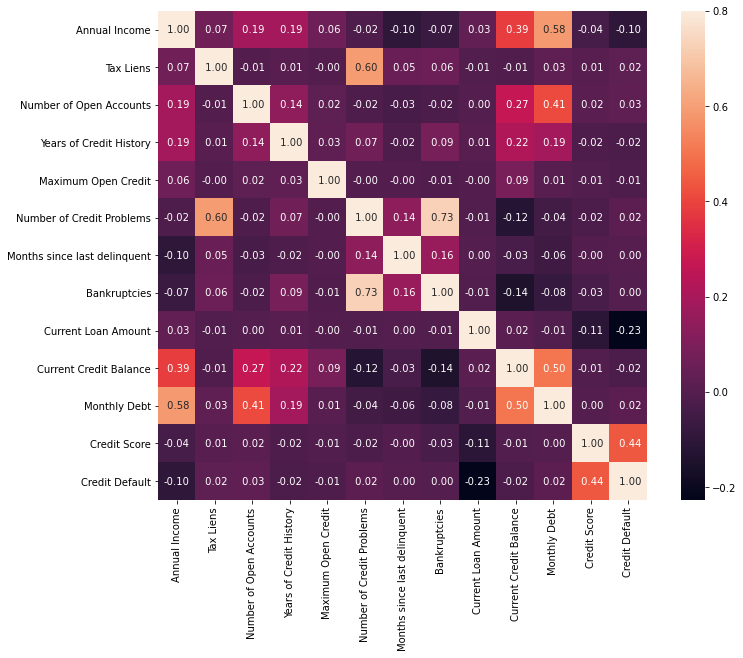

In [100]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_train.corr(), vmax=.8, annot=True, fmt=' .2f', square=True);

Из матрицы корреляции видно, что "Bankruptcies" и "Credit Problems" очень схожи. Возможно, один из этих признаков можно удалить

In [101]:
df_train.groupby('Years in current job')['Credit Default'].value_counts(normalize=True).head(40)

Years in current job  Credit Default
1 year                0                 0.718254
                      1                 0.281746
10+ years             0                 0.723842
                      1                 0.276158
2 years               0                 0.726241
                      1                 0.273759
3 years               0                 0.725806
                      1                 0.274194
4 years               0                 0.720682
                      1                 0.279318
5 years               0                 0.718992
                      1                 0.281008
6 years               0                 0.708920
                      1                 0.291080
7 years               0                 0.719697
                      1                 0.280303
8 years               0                 0.728614
                      1                 0.271386
9 years               0                 0.749035
                      1         

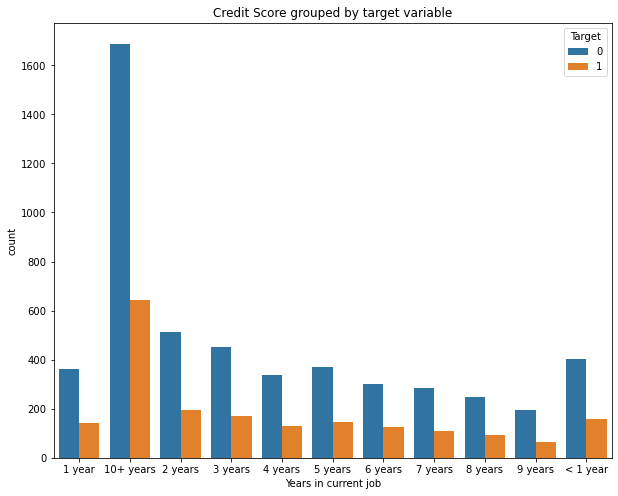

In [102]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=df_train['Credit Default'], data=df_train)
plt.title('Credit Score grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Появляется гипотеза, что количество лет можно разделить на меньшее количество категорий
* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы, можно разбить признак на несколько категорий
* Альтернативная гипотеза: расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

In [103]:
years_and_target_s = df_train.loc[df_train['Years in current job'].isin(['< 1 year', '1 year']), ['Monthly Debt','Years in current job', 'Credit Default']]

In [104]:
table = years_and_target_s.pivot_table(values='Monthly Debt', index='Years in current job', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Years in current job,,
1 year,362.0,142.0
< 1 year,404.0,159.0


In [105]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.9806417470773008

p-value выше уровня значимости 0,05. В итоге после различных проверок принято решение разбить признак на 2 категории: 1) меньше года и год 2) всё остальное. При разбиении на большее количество категорий растет precision, но страдает recall. Решение принято в пользу повышения recall.
Те же действия повторены с Tax Liens, Years of Credit History, Number of Open Accounts, Number of Credit Problems, а также с категориальными признаками Home Ownership и Purpose. 

### Очистка данных, создание новых признаков

Фичи, не сработавшие на кросс-валидации и валидационном кусочке датасета, закомментированы.
Пропуски в Annual_income и Credit Score заполнены с помощью регрессионной модели

In [106]:
class Dataset:
    
    def __init__(self):
        #self.median_income=None
        #self.median_years=None
        self.median_delinquent=None
        self.median_bankruptcies=None
        #self.median_score=None
        self.monthly_debt_min = None
        self.credit_balance_min = None
        
    def fit(self, df):
        #self.median_income=df['Annual Income'].median()
        #self.median_years='6 years'
        self.median_delinquent = df['Months since last delinquent'].median()
        self.median_bankruptcies=df['Bankruptcies'].median()
        #self.median_score = df['Credit Score'].median()
        self.monthly_debt_min = np.quantile(df['Monthly Debt'], q=0.1)
        self.credit_balance_min = np.quantile(df['Current Credit Balance'], q=0.1)
        
    def transform(self, df):
        df.loc[df['Monthly Debt'] < self.monthly_debt_min, 'Monthly Debt'] = self.monthly_debt_min
        df.loc[df['Current Credit Balance'] < self.credit_balance_min, 'Current Credit Balance'] = self.credit_balance_min
        df['Annual Income_nan'] = 0
        df.loc[df['Annual Income'].isna(), 'Annual Income_nan'] = 1
        df['Annual Income_nan'] = df['Annual Income_nan'].astype('uint8')
        df['Monthly_income'] = df['Annual Income']/12
        df.drop(['Annual Income'], axis=1, inplace=True)
        #df['Monthly_income'].fillna(self.median_income/12,inplace=True)
        
        df['Years in current job'] = df['Years in current job'].astype(str)
        #df['Years_nan'] = 0
        #df.loc[df['Years in current job'].isna(), 'Years_nan'] = 1
        
        for el in range(df.shape[0]):
            if df['Years in current job'].iloc[el] == '< 1 year' or df['Years in current job'].iloc[el] =='1 year' :
                df['Years in current job'].iloc[el] = '0'
            else:
                df['Years in current job'].iloc[el] = '1'
        df['Years in current job'] = df['Years in current job'].astype('int8')
                    
        df['Months since last delinquent'].fillna(self.median_delinquent, inplace=True)
        df['Bankruptcies'].fillna(self.median_bankruptcies, inplace=True)
        
        #df['Credit Score'].fillna(self.median_score, inplace=True)
        df.loc[df['Credit Score'] >=800, 'Credit Score'] = 500
        df['Years of Credit History'] = round(df['Years of Credit History'],0)
        df['Years of Credit History'] = df['Years of Credit History'].astype('int8')
    
        #df.loc[df['Number of Credit Problems'] <2, 'Number of Credit Problems'] = 0
        #df.loc[df['Number of Credit Problems'] >=2, 'Number of Credit Problems'] = 1 
        df.loc[df['Tax Liens'] <2, 'Tax Liens'] = 0
        df.loc[df['Tax Liens'] >=2, 'Tax Liens'] = 1
        df['Tax Liens'] = df['Tax Liens'].astype('int8')
        df.loc[df['Number of Open Accounts'] <3, 'Number of Open Accounts'] = 0
        df.loc[df['Number of Open Accounts'] >=3, 'Number of Open Accounts'] = 1
        df['Number of Open Accounts'] = df['Number of Open Accounts'].astype('int8')
        
        df['Purpose'] = df['Purpose'].astype(str)
        df.loc[(df['Purpose']== 'buy a car') | (df['Purpose']== 'buy house') | (df['Purpose']== 'home improvements') |
              (df['Purpose']== 'major purchase') | (df['Purpose']== 'moving') | (df['Purpose']== 'educational expenses') 
               , 'Purpose'] = 'purpose1'
        df.loc[(df['Purpose']== 'vacation') | (df['Purpose']== 'take a trip') | (df['Purpose']== 'wedding') 
               , 'Purpose'] = 'purpose2'
         # df.loc[(df['Purpose']== 'business loan') | (df['Purpose']== 'small business') | (df['Purpose']== 'renewable energy')
           #    , 'Purpose'] = 'purpose3'
        
        df.loc[df['Maximum Open Credit'] < df['Current Credit Balance'], 'Maximum Open Credit'] = df['Current Credit Balance']
        
        
        #df.loc[df['Current Loan Amount'] == 100000000, 'Current Loan Amount'] = df['Current Loan Amount'].mean()    
       # df.loc[df['Current Credit Balance'] < df['Monthly Debt'] , 'Current Credit Balance'] = df['Monthly Debt']        
               #df.loc[df['Years of Credit History'] <7, 'Years of Credit History'] = 0
        #df.loc[(df['Years of Credit History'] >=7) & (df['Years of Credit History'] <11), 'Years of Credit History'] = 1
        #df.loc[(df['Years of Credit History'] >=11) & (df['Years of Credit History'] <25), 'Years of Credit History'] = 2
        #df.loc[(df['Years of Credit History'] >=25) & (df['Years of Credit History'] <35), 'Years of Credit History'] = 3
        #df.loc[df['Years of Credit History'] >=35, 'Years of Credit History'] = 4
        
       # df = pd.get_dummies(df)
        
        df.drop(['Purpose_renewable energy', 'Bankruptcies', 'Months since last delinquent'], axis=1, errors='ignore',inplace=True)
        
        return df
    
    
    def regression(self, df, df_test): 
        """
        Заполняем пропуски в Monthly income и Credit Score с помощью регрессии. Очень важный признак для модели - Credit Default. 
        Для трейна он присутствует, а для теста нет. Поэтому для теста будем поочередно подставлять 0 и 1 в Credit Default и 
        возьмем гармоническое среднее от результатов
        """
            
        temp_train = df.loc[df['Monthly_income'].notnull()]
        temp_test = df.loc[df['Monthly_income'].isnull()]
        temp_y =temp_train['Monthly_income']
        temp_x_train = temp_train.drop(['Monthly_income', 'Annual Income_nan', 'Credit Score'], axis=1, inplace=False)
        temp_x_test = temp_test.drop(['Monthly_income', 'Annual Income_nan', 'Credit Score'], axis=1, inplace=False)
        cb_model = CatBoostRegressor(one_hot_max_size= 50,
            silent=True,
            learning_rate=0.05,
            iterations=350,
            eval_metric='R2',
            depth=5)
        cb_model.fit(temp_x_train, temp_y, cat_features=[0, 7, 8, 12])
        y_pred = cb_model.predict(temp_x_test)
        temp_test['Monthly_income'] = y_pred
        df['Monthly_income'].fillna(temp_test['Monthly_income'], inplace=True)
        
        temp_test2 = df_test.loc[df_test['Monthly_income'].isnull()]
        temp_test2['Credit Default'] = 0
        test = temp_test2.drop(['Monthly_income', 'Annual Income_nan', 'Credit Score'], axis=1, inplace=False)
        y_pred_test = cb_model.predict(test)
        temp_test2['Monthly_income_0'] = y_pred_test
        temp_test2['Credit Default'] = 1
        test = temp_test2.drop(['Monthly_income', 'Monthly_income_0', 'Annual Income_nan', 'Credit Score'], axis=1, inplace=False)
        y_pred_test2 = cb_model.predict(test)
        temp_test2['Monthly_income_1'] = y_pred_test2
        temp_test2['Monthly_income'] = hmean([temp_test2['Monthly_income_1'], temp_test2['Monthly_income_0']])
        df_test['Monthly_income'].fillna(temp_test2['Monthly_income'], inplace=True)
        
    
        temp_train = df.loc[df['Credit Score'].notnull()]
        temp_test = df.loc[df['Credit Score'].isnull()]
        temp_y =temp_train['Credit Score']
        temp_x_train = temp_train.drop(['Credit Score'], axis=1, inplace=False)
        temp_x_test = temp_test.drop(['Credit Score'], axis=1, inplace=False)
        cb_model = CatBoostRegressor(one_hot_max_size=50,
            silent=True,
            learning_rate=0.05,
            iterations=350,
            eval_metric='R2',
            depth=5)
        cb_model.fit(temp_x_train, temp_y, cat_features=[0, 7, 8, 12, 13])
        y_pred = cb_model.predict(temp_x_test)
        temp_test['Credit Score'] = y_pred
        df['Credit Score'].fillna(temp_test['Credit Score'], inplace=True)
        temp_test2 = df_test.loc[df_test['Credit Score'].isnull()]
        temp_test2['Credit Default']=0
        test = temp_test2.drop(['Credit Score'], axis=1, inplace=False)

        y_pred_test = cb_model.predict(test)
        temp_test2['Credit Score_0'] = y_pred_test
        temp_test2['Credit Default']=1
        test = temp_test2.drop(['Credit Score', 'Credit Score_0'], axis=1, inplace=False)
        y_pred_test2 = cb_model.predict(test)
        temp_test2['Credit Score_1'] = y_pred_test2
        temp_test2['Credit Score'] = hmean([temp_test2['Credit Score_0'], temp_test2['Credit Score_1']])
        df_test['Credit Score'].fillna(temp_test2['Credit Score'], inplace=True)
        
        return df, df_test
    
    def features(self, df):
        df['Extra_money'] = df['Monthly_income'] - df['Monthly Debt']
        df['Extra_money_percent'] = round(df['Extra_money'] / df['Monthly_income'] *100,0)
        df['Extra_money_percent'] = df['Extra_money_percent'].astype('int8')
        df['Months_to_pay']= 0
        df.loc[df['Current Loan Amount']!=100000000, 'Months_to_pay'] = round(df['Current Loan Amount'] / df['Monthly Debt'], 0)
        
        df.loc[(df['Months_to_pay'] >0) & (df['Months_to_pay'] <=12), 'Months_to_pay'] = 1
        df.loc[(df['Months_to_pay'] >12) & (df['Months_to_pay'] <=36), 'Months_to_pay'] = 2
        df.loc[(df['Months_to_pay'] >24) & (df['Months_to_pay'] <=36), 'Months_to_pay'] = 3
        df.loc[(df['Months_to_pay'] >36) & (df['Months_to_pay'] <=60), 'Months_to_pay'] = 4
        df.loc[df['Months_to_pay'] >60, 'Months_to_pay'] = 5
        df['Months_to_pay'] = df['Months_to_pay'].astype('int8')
        df['Credit Score'] = df['Credit Score'].astype('int')
        df['Below limit'] = round(df['Current Credit Balance'] / df['Maximum Open Credit']*100, 0)
        df['Maximum Open Credit']= df['Maximum Open Credit'] // 1000*1000
        df['Current Loan Amount']= df['Current Loan Amount'] // 1000*1000
        df['Current Credit Balance']= df['Current Credit Balance'] // 1000*1000
        df['Monthly_income']= df['Monthly_income'] // 1000*1000
        df['Total_Income'] = df['Monthly_income']* df['Months_to_pay']

        
        return df

In [107]:
data = Dataset()
data.fit(df_train)
df_test['Credit Default']=0 # чтобы не менялся порядок столбцов с категориальными переменными
df_train = data.transform(df_train)
df_test = data.transform(df_test)
df_train, df_test = data.regression(df_train, df_test)
df_train = data.features(df_train)
df_test = data.features(df_test)
df_test.drop(['Credit Default'], axis=1, inplace=True)

In [108]:
df_train.columns

Index(['Home Ownership', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Annual Income_nan', 'Monthly_income',
       'Extra_money', 'Extra_money_percent', 'Months_to_pay', 'Below limit',
       'Total_Income'],
      dtype='object')

In [109]:
X_train = df_train.drop(['Credit Default'], axis=1, inplace=False)
y_train = df_train['Credit Default']

### Балансировка данных

In [110]:
from sklearn.utils import class_weight
weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(df_train['Credit Default']),
                                             df_train['Credit Default']))

In [111]:
weights

[0.6961202895860404, 1.7747278750591575]

Пробовала балансировать датасет с помощью добавления дубликатов строк с миноритарным значением целевой переменной и с помощью добавления синтетических данных
balance = ADASYN()
X_train, y_train = balance.fit_sample(X_train, y_train)
После добавления синтетических данных F1 при кросс-валидации на трейне подлетает до 0.83, но при тестировании на валидационном датасете F1 падает. Видимо, синтетические данные вредят правильному обучению модели в данном случае.
В итоге принято решение не добавлять дополнительные данные, а сбалансировать веса значений непосредственно в параметрах самой модели

Нормализация данных с помощью StandardScaler и MinMaxScaler не повлияла на результат работы модели. Поэтому оставляем данные в изначальном виде

In [112]:
#scaler = StandardScaler()
#NUM_FEATURE_NAMES = ['Monthly_income', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
#                     'Credit Score', 'Years of Credit History', 'Extra_money',
#                     'Extra_money_percent', 'Months_to_pay']

#df_norm = pd.concat([X_train, y_train], axis=1).copy()
#df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])


### Подбор и обучение модели

лучше всего себя показала модель catboost (опробованы lgbm, xgboost, randomforest, KNeighbors, votingclassifier - результат все равно не лучше, чем catboost)

In [113]:
parameters = [{'iterations': [200, 300, 350, 400, 450] , 'learning_rate':[0.01, 0.03, 0.05], 
               'depth': np.arange(4, 7), 'l2_leaf_reg': np.arange(3,5), 'random_state': [21, 42]}]

model = GridSearchCV(estimator=CatBoostClassifier(silent=True, auto_class_weights='Balanced', 
                    cat_features=[0, 7, 8, 13], one_hot_max_size=40), param_grid=parameters,  scoring='f1', cv=5)

In [269]:
model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000018476269748>,
             param_grid=[{'depth': array([4, 5, 6]),
                          'iterations': [200, 300, 350, 400, 450],
                          'l2_leaf_reg': array([3, 4]),
                          'learning_rate': [0.01, 0.03, 0.05],
                          'random_state': [21, 42]}],
             scoring='f1')

In [270]:
model.best_params_

{'depth': 5,
 'iterations': 400,
 'l2_leaf_reg': 4,
 'learning_rate': 0.03,
 'random_state': 21}

In [114]:
model_catb = CatBoostClassifier(silent=True, iterations=400, learning_rate=0.03, depth=5, l2_leaf_reg=4, 
                                auto_class_weights='Balanced', random_state=21, eval_metric='F1',
                               cat_features=[0, 7, 8, 13], one_hot_max_size=40, early_stopping_rounds=50)

recall = cross_val_score(model_catb, X_train, y_train, cv=5, scoring='recall')
print('Recall:', round(np.mean(recall),3))
precision = cross_val_score(model_catb, X_train, y_train, cv=5, scoring='precision')
print('Precision:', round(np.mean(precision),3))
f1 = cross_val_score(model_catb, X_train, y_train, cv=5, scoring='f1')
print('F1:', round(np.mean(f1),3))

Recall: 0.699
Precision: 0.618
F1: 0.656


Результат на кросс-валидации явно выше, чем будет на тесте, т.к. регрессия для заполнения income и credit score, которая в значительной степени опирается на credit default, построена более точно. Попробуем разбить изначальный датасет на train и valid для получения более независимых результатов

In [115]:
df= pd.read_csv('C:/Users/yana/course_project/course_project_train.csv')
reduce_mem_usage(df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.500000,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.500000,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.099998,1778920.0,0.0,NaN,0.0,buy a car,Short Term,100000000.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.500000,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [116]:
X = df.drop(['Credit Default'], axis=1, inplace=False)
y = df['Credit Default']
X_train2, X_valid, y_train2, y_valid = train_test_split(X, y, test_size=0.30, random_state=42)

In [117]:
df_check = pd.concat([X_train2, y_train2], axis=1)

In [118]:
data2 = Dataset()
data2.fit(df_check)
df_check = data2.transform(df_check)
X_valid['Credit Default']=0
X_valid = data2.transform(X_valid)
df_check, X_valid = data2.regression(df_check, X_valid)
df_check = data2.features(df_check)
X_valid = data2.features(X_valid)
X_valid.drop(['Credit Default'], axis=1, inplace=True)

In [119]:
X_train2 = df_check.drop(['Credit Default'], axis=1, inplace=False)
y_train2 = df_check['Credit Default']

In [120]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [121]:
model_catb = CatBoostClassifier(iterations=400, learning_rate=0.03, depth=6, l2_leaf_reg=4, 
                                auto_class_weights='Balanced', random_state=42,
                               cat_features=[0, 7, 8, 13], one_hot_max_size=40)
model_catb.fit(X_train2, y_train2,
          eval_set=(X_valid, y_valid),
          use_best_model=True,
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6709646	test: 0.6808492	best: 0.6808492 (0)	total: 14.8ms	remaining: 5.91s
1:	learn: 0.6490466	test: 0.6671188	best: 0.6671188 (1)	total: 23.7ms	remaining: 4.71s
2:	learn: 0.6309013	test: 0.6576631	best: 0.6576631 (2)	total: 32.5ms	remaining: 4.31s
3:	learn: 0.6119213	test: 0.6474379	best: 0.6474379 (3)	total: 40.8ms	remaining: 4.04s
4:	learn: 0.5968663	test: 0.6408731	best: 0.6408731 (4)	total: 49.1ms	remaining: 3.88s
5:	learn: 0.5838193	test: 0.6330148	best: 0.6330148 (5)	total: 71.5ms	remaining: 4.69s
6:	learn: 0.5752922	test: 0.6273301	best: 0.6273301 (6)	total: 80ms	remaining: 4.49s
7:	learn: 0.5643659	test: 0.6229052	best: 0.6229052 (7)	total: 88.6ms	remaining: 4.34s
8:	learn: 0.5576493	test: 0.6180803	best: 0.6180803 (8)	total: 97.1ms	remaining: 4.22s
9:	learn: 0.5485739	test: 0.6143998	best: 0.6143998 (9)	total: 105ms	remaining: 4.1s
10:	learn: 0.5397437	test: 0.6112546	best: 0.6112546 (10)	total: 113ms	remaining: 4.01s
11:	learn: 0.5323682	test: 0.6052346	best: 0.6

103:	learn: 0.4008291	test: 0.5720849	best: 0.5706881 (98)	total: 946ms	remaining: 2.69s
104:	learn: 0.4005830	test: 0.5721276	best: 0.5706881 (98)	total: 954ms	remaining: 2.68s
105:	learn: 0.4001171	test: 0.5721433	best: 0.5706881 (98)	total: 962ms	remaining: 2.67s
106:	learn: 0.3997837	test: 0.5720095	best: 0.5706881 (98)	total: 971ms	remaining: 2.66s
107:	learn: 0.3986595	test: 0.5735386	best: 0.5706881 (98)	total: 980ms	remaining: 2.65s
108:	learn: 0.3984649	test: 0.5735870	best: 0.5706881 (98)	total: 990ms	remaining: 2.64s
109:	learn: 0.3980640	test: 0.5734285	best: 0.5706881 (98)	total: 999ms	remaining: 2.63s
110:	learn: 0.3977474	test: 0.5733968	best: 0.5706881 (98)	total: 1.01s	remaining: 2.62s
111:	learn: 0.3973023	test: 0.5733207	best: 0.5706881 (98)	total: 1.02s	remaining: 2.61s
112:	learn: 0.3969291	test: 0.5731499	best: 0.5706881 (98)	total: 1.02s	remaining: 2.6s
113:	learn: 0.3966319	test: 0.5731851	best: 0.5706881 (98)	total: 1.04s	remaining: 2.6s
114:	learn: 0.3962986	t

198:	learn: 0.3714165	test: 0.5785336	best: 0.5706881 (98)	total: 1.79s	remaining: 1.81s
199:	learn: 0.3711733	test: 0.5784913	best: 0.5706881 (98)	total: 1.8s	remaining: 1.8s
200:	learn: 0.3709548	test: 0.5784526	best: 0.5706881 (98)	total: 1.81s	remaining: 1.79s
201:	learn: 0.3707491	test: 0.5782587	best: 0.5706881 (98)	total: 1.82s	remaining: 1.78s
202:	learn: 0.3706130	test: 0.5782300	best: 0.5706881 (98)	total: 1.83s	remaining: 1.77s
203:	learn: 0.3700130	test: 0.5797045	best: 0.5706881 (98)	total: 1.83s	remaining: 1.76s
204:	learn: 0.3697389	test: 0.5795561	best: 0.5706881 (98)	total: 1.84s	remaining: 1.75s
205:	learn: 0.3694584	test: 0.5796753	best: 0.5706881 (98)	total: 1.85s	remaining: 1.74s
206:	learn: 0.3692507	test: 0.5797063	best: 0.5706881 (98)	total: 1.86s	remaining: 1.73s
207:	learn: 0.3691714	test: 0.5797230	best: 0.5706881 (98)	total: 1.87s	remaining: 1.72s
208:	learn: 0.3688558	test: 0.5796417	best: 0.5706881 (98)	total: 1.88s	remaining: 1.71s
209:	learn: 0.3686861	t

302:	learn: 0.3446187	test: 0.5829503	best: 0.5706881 (98)	total: 2.72s	remaining: 871ms
303:	learn: 0.3444090	test: 0.5831275	best: 0.5706881 (98)	total: 2.73s	remaining: 863ms
304:	learn: 0.3440688	test: 0.5831929	best: 0.5706881 (98)	total: 2.74s	remaining: 854ms
305:	learn: 0.3438532	test: 0.5831140	best: 0.5706881 (98)	total: 2.75s	remaining: 845ms
306:	learn: 0.3436255	test: 0.5830712	best: 0.5706881 (98)	total: 2.76s	remaining: 836ms
307:	learn: 0.3434043	test: 0.5831337	best: 0.5706881 (98)	total: 2.77s	remaining: 827ms
308:	learn: 0.3432412	test: 0.5831250	best: 0.5706881 (98)	total: 2.78s	remaining: 818ms
309:	learn: 0.3430321	test: 0.5829432	best: 0.5706881 (98)	total: 2.78s	remaining: 808ms
310:	learn: 0.3426148	test: 0.5830397	best: 0.5706881 (98)	total: 2.79s	remaining: 799ms
311:	learn: 0.3423531	test: 0.5830548	best: 0.5706881 (98)	total: 2.8s	remaining: 790ms
312:	learn: 0.3420482	test: 0.5830893	best: 0.5706881 (98)	total: 2.81s	remaining: 781ms
313:	learn: 0.3418445	

На валидационном датасете при глубине 6 результаты лучше, чем при 5. Попробуем уменьшить кол-во итераций до 99. При 400 или 99 итерациях результат на валидационном датасете практически одинаковый, но при 400 итерациях разница между результатами на трейне и на валиде больше 10%, что говорит о высокой вероятности переобучения.  Но поскольку данных в полном трейне и в тесте больше, чем в этой модели, устанавливать маленькое кол-во итераций кажется рискованным. Лучше увеличить кол-во итераций, но установить early stopping rounds 

In [122]:
model_catb = CatBoostClassifier(silent=True, iterations=99, learning_rate=0.03, depth=6, l2_leaf_reg=4, 
                                auto_class_weights='Balanced', random_state=21,
                               cat_features=[0, 7, 8, 13], one_hot_max_size=40)
model_catb.fit(X_train2, y_train2)

y_train_pred = model_catb.predict(X_train2)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train2, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      3795
           1       0.68      0.70      0.69      1455

    accuracy                           0.83      5250
   macro avg       0.78      0.79      0.78      5250
weighted avg       0.83      0.83      0.83      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1592
           1       0.53      0.58      0.55       658

    accuracy                           0.72      2250
   macro avg       0.67      0.68      0.68      2250
weighted avg       0.73      0.72      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1248  344
1                277  381


In [123]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))
    
    
    plt.show()

In [124]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [125]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

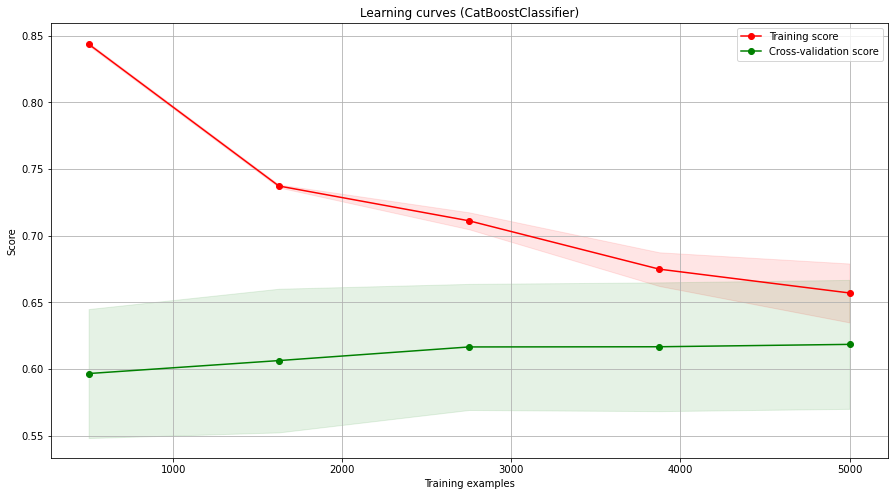

In [126]:
show_learning_curve_plot(model_catb, X_train2.append(X_valid), y_train2.append(y_valid))

кривые постепенно сближаются, слишком сильного сближения нет ни при 99 итерациях, ни при 400. 

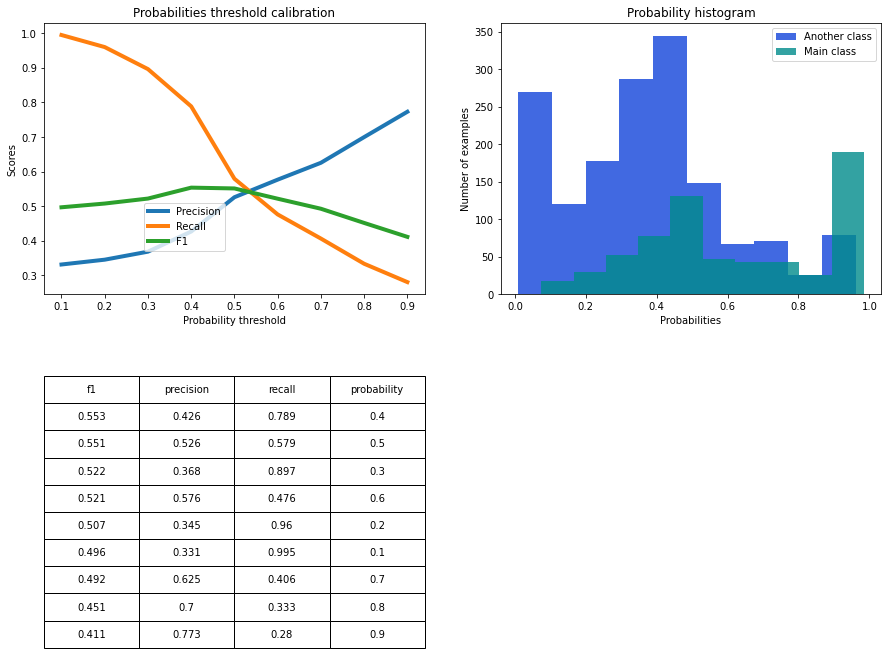

In [127]:
y_test_pred_probs = model_catb.predict_proba(X_valid)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_valid)

Поскольку данные уже были сбалансированы в модели, лучшая вероятность отнесения к классу остается 0.5

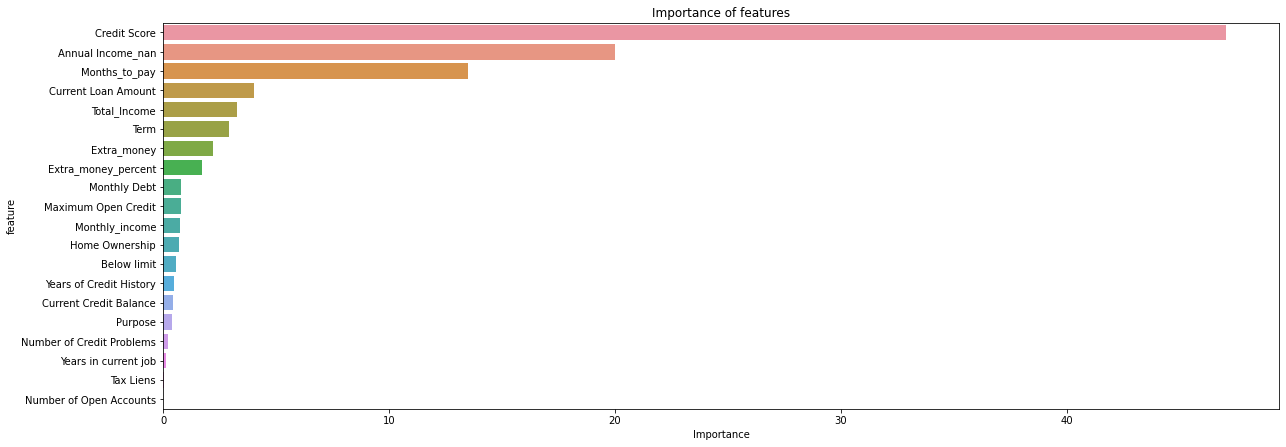

In [128]:
important_features_top = show_feature_importances(X_train2.columns, model_catb.feature_importances_, get_top=20)

In [129]:
# cat feature с индексом 11 иногда получает индекс 10 (веса признаков почти равны), поэтому может сработать с ошибкой
model_catb3 = CatBoostClassifier(silent=True, iterations=99, learning_rate=0.03, depth=6, l2_leaf_reg=4, 
                                auto_class_weights='Balanced', random_state=42,
                               cat_features=[1, 5, 11,15], one_hot_max_size=40)
model_catb3.fit(X_train2[important_features_top], y_train2)

y_train_pred = model_catb3.predict(X_train2[important_features_top])
y_valid_pred = model_catb3.predict(X_valid[important_features_top])
y_valid_pred_probs = model_catb3.predict_proba(X_valid[important_features_top])

get_classification_report(y_train2, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3795
           1       0.67      0.71      0.69      1455

    accuracy                           0.82      5250
   macro avg       0.78      0.79      0.78      5250
weighted avg       0.83      0.82      0.82      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1592
           1       0.51      0.59      0.54       658

    accuracy                           0.71      2250
   macro avg       0.66      0.68      0.67      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1214  378
1                271  387


при удалении наименее важных признаков результат стал хуже. Оставим все признаки

### Обучение финальной модели

In [130]:
final_model = CatBoostClassifier(silent=True, iterations=380, learning_rate=0.03, depth=6, l2_leaf_reg=4, 
                                auto_class_weights='Balanced', random_state=42, eval_metric='F1',
                               cat_features=[0, 7, 8, 13], one_hot_max_size=40, early_stopping_rounds=50)

In [131]:
final_model.fit(X_train, y_train)

y_pred = final_model.predict(df_test)
predictions = pd.DataFrame({'Id': np.arange(0,y_pred.shape[0]), 'Credit Default': y_pred})

predictions.to_csv('YAbakumova_predictions.csv', index=False)

predictions.head(5)

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0


In [132]:
predictions.shape

(2500, 2)